# Tarea 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, bisect
from scipy.constants import Boltzmann
from scipy.interpolate import CubicSpline

## Experiencia 1

Extraimos los datos del primer circuito en un dataframe

In [2]:
datos=pd.read_table('circuito1.txt',header=0)

Graficamos

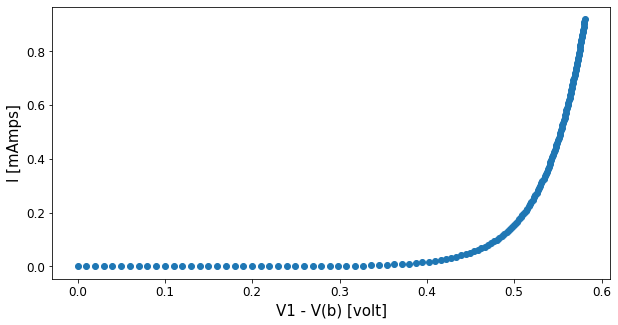

In [3]:
V = datos['v1']-datos['V(n002)']
I = datos['I(D1)']

plt.figure(figsize=(10,5))
plt.plot(V, 1000*I, 'o')
plt.xlabel('V1 - V(b) [volt]', size=15)
plt.ylabel('I [mAmps]', size=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Definimos la funcion para realizar el ajuste: 

$$I(V) = a(e^{bV}-1)$$

En donde $a=I_0$ y $b = \frac{q}{KT}$

In [4]:
# Constantes:
K = Boltzmann
q = 1.602176634*(10**-19) # Coulomb

def corriente_I(V, a, b):
    return a*(np.exp(b*V)-1)

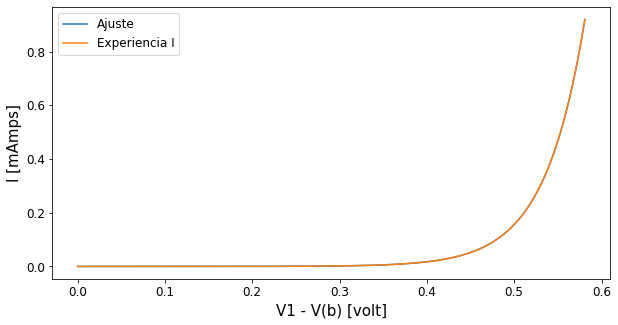

I_0 =  2.7016782478780414e-09
T =  529.1817203119546


In [5]:
# fiteo
I_fit = curve_fit(corriente_I, V, I)
I_teo = corriente_I(V, I_fit[0][0], I_fit[0][1])

# graficamos
plt.figure(figsize=(10,5))
plt.plot(V, 1000*I_teo, label='Ajuste')
plt.plot(V, 1000*I, label='Experiencia I')
plt.xlabel('V1 - V(b) [volt]', size=15)
plt.ylabel('I [mAmps]', size=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(prop={'size': 12})
plt.show()

print('I_0 = ', I_fit[0][0] )
print('T = ', q/(K*I_fit[0][1]))

In [6]:
RMS = np.sqrt(sum((I_teo-I)**2)/(len(I)))
print('Raiz del Error cuadrático medio:', RMS*1000, '[mAmps]')

Raiz del Error cuadrático medio: 0.0002644361495808102 [mAmps]


Expresion para $V_{out}$ :

$$V_{out} = R I_0 ( e^{\frac{(V_{in}-V_{out})q}{KT}} - 1)$$

Encontraremos los ceros para la funcion:

$$g(V_{out}) = V_{out} = R I_0 ( e^{(V_{in}-V_{out})b} - 1) - V{out}$$

con $b = \frac{q}{KT}$, de modo que lo ceros de esta funcion sean los $V_{out}$ que satisfacen la primera ecuacion

In [7]:
# Constantes
R = 1000
I0 = I_fit[0][0]
b = I_fit[0][1]

# voltaje de entrada y salida
V_in = datos['v1']
V_out=np.zeros(len(V_in))

# funcion que se buscara ceros
def g(v_out):
    return R*I0*(np.exp((V_in[i]-v_out)*b)-1) - v_out

for i in range(len(V_in)):
    V_out[i] = bisect(g,10,-10)

Visualicemos los datos para $V_{out}$ obtenidos de LTSPICE

In [8]:
V_outLTspice = datos['V(n002)']
V_outLTspice

0      0.000000e+00
1      6.222022e-07
2      1.398011e-06
3      2.365343e-06
4      3.571466e-06
           ...     
146    8.810652e-01
147    8.905734e-01
148    9.000865e-01
149    9.096044e-01
150    9.191271e-01
Name: V(n002), Length: 151, dtype: float64

Graficamos el medido en LTSPICE y el obtenido con la ecuación:

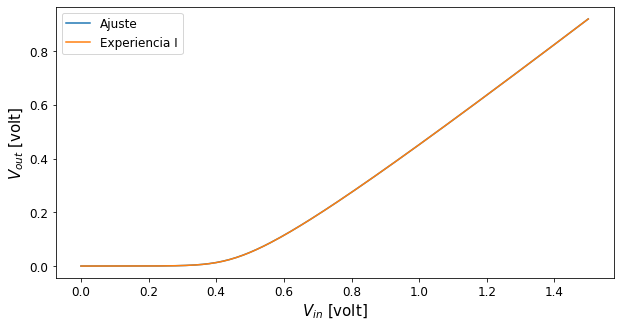

In [9]:
plt.figure(figsize=(10,5))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(V_in, V_out, label='Ajuste')
plt.plot(V_in, V_outLTspice, label='Experiencia I')
plt.xlabel('$V_{in}$ [volt]', size=15)
plt.ylabel('$V_{out}$ [volt]', size=15)
plt.legend(prop={'size': 12})
plt.show()

## Experiencia 2

Extrapolamos $V_{out}$ con CubicSpline para calcular la derivada

In [10]:
# pasamos a array
V_in = np.array(V_in)

# expandimos
Vind = np.append(V_in, [1.51, 1.52, 1.53])

# extrapolamos
cs = CubicSpline(V_in, V_out)

Voutd = cs(Vind)

Calcula las derivadas:

In [11]:
dV_out  = np.zeros(len(Voutd))
d2V_out = np.zeros(len(Voutd))
d3V_out = np.zeros(len(Voutd))
d4V_out = np.zeros(len(Voutd))

for i in range(len(V_out)):
    # V_in[i+1] - V_in[i] = constante = 0.01
    h = V_in[1]-V_in[0]
    
    # primera derivada
    dV_out[i]  = (Voutd[i+1]-Voutd[i])/(h)
    
    # segunda derivada
    d2V_out[i] = (dV_out[i+1]-dV_out[i])/(h)
    
    # tercera derivada
    d3V_out[i] = (d2V_out[i+1]-d2V_out[i])/(h)
    
    # cuarta derivada
    d4V_out[i] = (d3V_out[i+1]-d3V_out[i])/(h)
    
# necesitamos los arrays correspondientes a V_in en [0, 1.5]
dV_out  = dV_out[:151]
d2V_out = d2V_out[:151]
d3V_out = d3V_out[:151]
d4V_out = d4V_out[:151]

Calculamos el radio de curvatura y el radio minimo

In [12]:
R_c = abs((1+dV_out**2)**(3/2))/abs(d2V_out)
i = np.where( R_c==min(R_c))
print('El radio minimo es: ', '{:.3F}'.format(float(R_c[i])),
      ', que corresponde a un V_in = ', '{:.3F}'.format(float(V_in[i])),
      ' y un V_out = ', '{:.3F}'.format(float(V_out[i])))

El radio minimo es:  0.026 , que corresponde a un V_in =  0.590  y un V_out =  0.107
